# Предсказание клиентов, склонных к оттоку, в сети розничных продуктовых магазинов

**Описание данных:**
- `transactions.parquet` - чековые данные 
     - chq_id - id чека
     - plant - id магазина
     - chq_date - дата транзакции
     - chq_position - номер позиции товара в чеке
     - client_id - id клиента
     - material - id товара
     - sales_count - кол-во товара в чеке
     - sales_sum - стоимость указанных единиц товара в чеке
     - is_promo - был ли товар на промо-акции
- `materials.csv` - справочник товаров 
     - material - id товара
     - hier_level_1 - категория товара 1(еда/не еда)
     - hier_level_2 - категория товара 2(зашифрован)
     - hier_level_3 - категория товара 3(зашифрован)
     - hier_level_4 - категория товара 4(зашифрован)
     - vendor - id производителя
     - is_private_label - принадлежность товара к внутреннему бренду
     - is_alco - принадлежность товара к алкогольной продукции
- `plants.csv` - справочник магазинов 
    - plant - id магазина
    - plant_type - тип магазина (супермаркет или гипермаркет)
    - city - город, где расположен магазин
- `clients.csv` - справочник клиентов 
    - client_id - id клиента
    - gender - пол клиента
    - city - город, где клиент совершает покупки чаще всего
    - birthyear - год рождения клиента


**Цель:**

- проанализировать данные и определить оптимальную методологию определения отточных клиентов

- разработать модель вероятности оттока клиентов

- дать интерпретацию разработанной модели, ответить на вопросы: какие признаки наиболее влияют на отток клиентов, подумать о репрезентативности полученных вероятностей, насколько они соответствуют действительности.


# 0.Выгрузка данных

**Выгрузка сырых данных в pandas-датафреймы, заполнение пропусков и склейка датафреймов в единый датафрейм с транзакциями, аггрегация датафрейма с транзакциями по чекам**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
clients_df = pd.read_csv('clients.csv')
clients_df.head()

,client_id,gender,city,birthyear
0,1a47d62dddacc03fe90c15652f7ae1a4,M,Other,1990.0
1,9cb909f701d25d548e953bff81192b56,F,Other,1969.0
2,d5da0f5b841b4f83383202807995027a,M,Other,1976.0
3,13ed7f16810b17b8cee6de834ac79a48,F,Moscow,1966.0
4,215fe3ea7d5bf0415e5504e2a7f33551,F,Other,1988.0


In [4]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99995 entries, 0 to 99994
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  99995 non-null  object 
 1   gender     99640 non-null  object 
 2   city       99995 non-null  object 
 3   birthyear  98219 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.1+ MB


In [5]:
#заполним пропуски в колонке gender самым частым значением, а в birthyear - медианой 

clients_df['gender'] = clients_df['gender'].fillna(clients_df['gender'].value_counts()[0])
clients_df['birthyear'] = clients_df['birthyear'].fillna(clients_df['birthyear'].median())

In [7]:
materials_df = pd.read_csv('materials.csv')
materials_df.head()

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco
0,35cbdf61de9e19c8b417327aaef14c88,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,9eed45f71360b4b1e2590637467220e5,212a38db0ddcd009f1e164cc8483485c,0,0
1,c0b0bf24d4ec71da3d304f761ec555d8,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,de2eb747e0896c050905a6b635ab800a,9b0b6c7d55413ad3b67761b7b125b534,0,0
2,f0fc5e654a81a7c4b8ba8d7c26546e14,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,8a969031832c535daf96e0c2aed8e814,9b0b6c7d55413ad3b67761b7b125b534,0,0
3,353693e64fb5f9e2d29746d7fe6edf1e,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,b58f7d184743106a8a66028b7a28937c,4c0dc012ebb679a18b244c53c6f59b5a,a3c8be149d718771e892619bd310b961,0,0
4,5d9e0b4302ce95448cae72165ff4cf5b,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,b58f7d184743106a8a66028b7a28937c,4c0dc012ebb679a18b244c53c6f59b5a,a3c8be149d718771e892619bd310b961,0,0


In [8]:
materials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105609 entries, 0 to 105608
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   material          105609 non-null  object
 1   hier_level_1      105609 non-null  object
 2   hier_level_2      105609 non-null  object
 3   hier_level_3      105609 non-null  object
 4   hier_level_4      105609 non-null  object
 5   vendor            105609 non-null  object
 6   is_private_label  105609 non-null  int64 
 7   is_alco           105609 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.4+ MB


In [9]:
plants_df = pd.read_csv('plants.csv')
plants_df.head()

,plant,plant_type,city
0,95b09698fda1f64af16708ffb859eab9,HM,St. Petersburg
1,926abae84a4bd33c834bc6b981b8cf30,HM,St. Petersburg
2,ae2bac2e4b4da805d01b2952d7e35ba4,HM,St. Petersburg
3,0e7e3cf0ded4d9db8b376b317c007f99,HM,St. Petersburg
4,540bd55a2cf295b8ea9cd78650e89d03,HM,St. Petersburg


In [10]:
plants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   plant       388 non-null    object
 1   plant_type  388 non-null    object
 2   city        388 non-null    object
dtypes: object(3)
memory usage: 9.2+ KB


In [11]:
df = pd.read_parquet('transactions.parquet', engine='pyarrow')

df.head()

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.0,249.99,1
2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,012,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,013,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,011,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.0,53.98,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32109414 entries, 0 to 32109413
Data columns (total 9 columns):
 #   Column        Dtype         
---  ------        -----         
 0   chq_id        object        
 1   plant         object        
 2   chq_date      datetime64[ns]
 3   chq_position  object        
 4   client_id     object        
 5   material      object        
 6   sales_count   float64       
 7   sales_sum     float64       
 8   is_promo      int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 2.2+ GB


In [13]:
df.isna().sum()

chq_id          0
plant           0
chq_date        0
chq_position    0
client_id       0
material        0
sales_count     0
sales_sum       0
is_promo        0
dtype: int64

In [14]:
#склеим сырые данные в один датафрейм с транзакциями,
#из таблицы materials возьмем только столбцы material,hier_level_1, is_private_label, is_alco,
#так как остальные столбцы содержат много уникальных значений, их будет сложно аггрегировать 

df = df.merge(clients_df, left_on='client_id', right_on='client_id', how='left') \
       .merge((materials_df.drop(['hier_level_2', 'hier_level_3', 'hier_level_4', 'vendor'], axis=1)),
                                left_on='material', right_on='material', how='left') \
       .merge(plants_df, left_on='plant', right_on='plant', how='left')
df.head()

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,gender,city_x,birthyear,hier_level_1,is_private_label,is_alco,plant_type,city_y
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0,M,St. Petersburg,1957.0,FOOD,0.0,0.0,HM,St. Petersburg
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.0,249.99,1,M,St. Petersburg,1957.0,FOOD,0.0,0.0,HM,St. Petersburg
2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,012,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1,M,St. Petersburg,1957.0,FOOD,0.0,1.0,HM,St. Petersburg
3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,013,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1,M,St. Petersburg,1957.0,FOOD,0.0,1.0,HM,St. Petersburg
4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,011,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.0,53.98,1,M,St. Petersburg,1957.0,FOOD,0.0,0.0,HM,St. Petersburg


In [15]:
print(f'Данные собраны за период с' ,df['chq_date'].min().date(), 'по', df['chq_date'].max().date())

Данные собраны за период с 2016-10-04 по 2017-10-04


In [16]:
df.isna().sum()

chq_id                  0
plant                   0
chq_date                0
chq_position            0
client_id               0
material                0
sales_count             0
sales_sum               0
is_promo                0
gender               1616
city_x               1616
birthyear            1616
hier_level_1        13139
is_private_label    13139
is_alco             13139
plant_type              0
city_y                  0
dtype: int64

In [17]:
#заменим значения в бинарных колонках на 1/0

df['hier_level_1'] = df['hier_level_1'].map({'FOOD' : 1, 'NONFOOD' : 0})
df['gender'] = df['gender'].map({'M' : 1, 'F' : 0})
df.head()

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,gender,city_x,birthyear,hier_level_1,is_private_label,is_alco,plant_type,city_y
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0,1.0,St. Petersburg,1957.0,1.0,0.0,0.0,HM,St. Petersburg
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.0,249.99,1,1.0,St. Petersburg,1957.0,1.0,0.0,0.0,HM,St. Petersburg
2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,012,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1,1.0,St. Petersburg,1957.0,1.0,0.0,1.0,HM,St. Petersburg
3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,013,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1,1.0,St. Petersburg,1957.0,1.0,0.0,1.0,HM,St. Petersburg
4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,011,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.0,53.98,1,1.0,St. Petersburg,1957.0,1.0,0.0,0.0,HM,St. Petersburg


In [18]:
#Заполняем пропуски 

df['gender'].fillna(int(df['gender'].mode()), inplace=True)
df['city_x'].fillna('Other', inplace=True)
df['birthyear'].fillna(df['birthyear'].median(), inplace=True)
df['hier_level_1'].fillna(0, inplace=True)
df['is_private_label'].fillna(0, inplace=True)
df['is_alco'].fillna(0, inplace=True)

In [19]:
#проверка на пропуски

df.isna().any().any()

False

In [20]:
#создание датафрейма, саггрегированного по чекам

def aggregate_df_by_chq(df):
    
    #аггрегируем df по chq_id
    agg_by_chq_df = df.groupby('chq_id', as_index=False).agg({
                                                      'material' : 'count',
                                                      'chq_date' : 'min',
                                                      'client_id' : 'min',
                                                      'sales_sum' : 'sum',
                                                      'is_promo' : 'sum',
                                                      'hier_level_1' : 'sum',
                                                      'is_private_label' : 'sum', 
                                                      'is_alco' : 'sum',
                                                      'city_x' : 'max',
                                                      'gender' : 'max',
                                                      'birthyear' : 'max',
                                                      'plant_type' : 'max',
                                                      'city_y' : 'max'
                                                     })
    
    #создадим признак, который показывает скользящую разницу между чеками клиента в днях 
    agg_by_chq_df['datediff'] = agg_by_chq_df.sort_values('chq_date') \
                                             .groupby(['client_id'], as_index=False)['chq_date'] \
                                             .diff()
    
    agg_by_chq_df['datediff'] = agg_by_chq_df['datediff'].dt.days
    
    
    #проверяем, что в столбце datediff у каждого клиента есть только один пропуск - у первого заказа
    if df['client_id'].nunique() != agg_by_chq_df['datediff'].isnull().sum():
        
        return 'Ошибка при подсчете разницы между заказами в днях'
    
    #заполняем эти пропуски нулями
    agg_by_chq_df['datediff'].fillna(0, inplace=True)
    
    #создаем признаки-доли для бинарных столбцов is_promo, hier_level_1, is_private_label, is_alco
    agg_by_chq_df['is_promo_rate'] = agg_by_chq_df['is_promo'] / agg_by_chq_df['material']
    agg_by_chq_df['hier_level_1_rate'] = agg_by_chq_df['hier_level_1'] / agg_by_chq_df['material']
    agg_by_chq_df['is_private_label_rate'] = agg_by_chq_df['is_private_label'] / agg_by_chq_df['material']
    agg_by_chq_df['is_alco_rate'] = agg_by_chq_df['is_alco'] / agg_by_chq_df['material']
    
    agg_by_chq_df = agg_by_chq_df.drop(['is_promo', 'hier_level_1', 'is_private_label', 'is_alco'], axis=1)
    
    
    return agg_by_chq_df

In [21]:
agg_by_chq_df = aggregate_df_by_chq(df)
agg_by_chq_df.head()

,chq_id,material,chq_date,client_id,sales_sum,city_x,gender,birthyear,plant_type,city_y,datediff,is_promo_rate,hier_level_1_rate,is_private_label_rate,is_alco_rate
0,00000391443926003b45cebac9a4c0b2,2,2017-01-14,8a5c839e26cb4a6eedadce113cceb253,164.0,Other,1.0,1989.0,SM,Other,3.0,1.000000,1.000000,0.000000,0.0
1,0000086694a97b18d2b5e5cfc309ab76,8,2017-07-22,191412d730a981ce6ae809b8ef8a1070,821.0,Moscow,0.0,1987.0,SM,Moscow,3.0,0.125000,0.875000,0.125000,0.0
2,00000b7bb8fd947f62aeed1bba4b6fbb,6,2016-11-13,19c47bc27fdb0c828ef60074a67b8733,326.0,Other,0.0,1969.0,HM,Other,28.0,0.500000,0.833333,0.333333,0.0
3,00000d5d627d67cacb2ba17705635ca7,7,2017-05-28,c045e1f39fd88c7c8b3afac0b3cd1778,1713.0,Other,1.0,1963.0,HM,Other,2.0,0.285714,0.857143,0.142857,0.0
4,000010ba9e98d7316de3a8a862fc2d49,19,2017-02-21,f277f6302e334cb8d9324fd386e7ba5b,2032.0,Other,1.0,1992.0,HM,Other,4.0,0.315789,0.947368,0.210526,0.0


In [4]:
# agg_by_chq_df.to_csv('agg_by_chq_df.csv', index=False)
agg_by_chq_df = pd.read_csv('agg_by_chq_df.csv', parse_dates=['chq_date'])

# EDA
 **Предварительный анализ данных о чеках:**
- по времени
- сумме
- группам клиентов (город, возраст, год рождения)
- информации о товаре (hier_level_1, is_alco, is_private_label, is_promo)
- разности дней между чеками у отдельных клиентов

Посмотрим на распределение суммы чеков. Из графика видно, что у распределение далеко от нормального, имеет очень тяжелые хвосты в обе стороны.

На графике есть чеки с отрицательной суммой. Скорее всего, это возвраты. Они могут помешать дальнейшему анализу и обучению модели, поэтому от них лучше избавиться

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение суммы чеков')

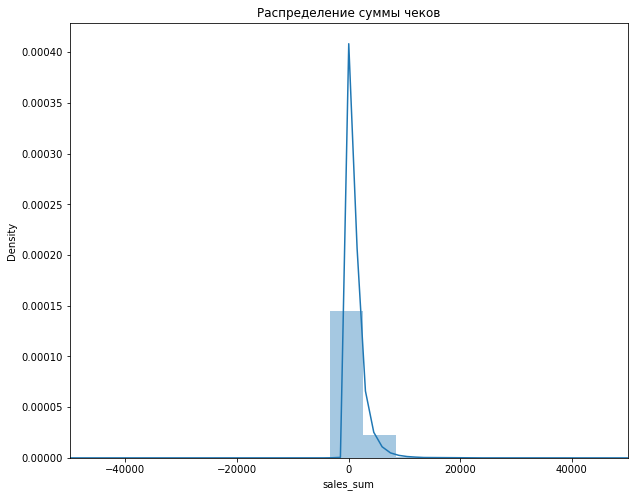

In [5]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.distplot(agg_by_chq_df['sales_sum'])
plt.xlim((-50000, 50000))
plt.title('Распределение суммы чеков')

In [6]:
print('Процент чеков с отрицательной суммой - ',
      agg_by_chq_df[agg_by_chq_df['sales_sum'] <= 0].shape[0] / agg_by_chq_df.shape[0] * 100)

Процент чеков с отрицательной суммой -  0.5018256022801055


In [7]:
agg_by_chq_df = agg_by_chq_df[agg_by_chq_df['sales_sum'] >= 0]

Посмотрим на boxplot без крайних 5% значений-выбросов 

<AxesSubplot:xlabel='sales_sum'>

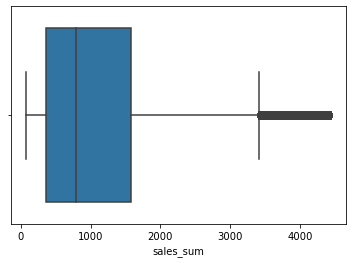

In [8]:
sns.boxplot(data=agg_by_chq_df[(agg_by_chq_df['sales_sum'] >= agg_by_chq_df['sales_sum'].quantile(0.05)) & 
              (agg_by_chq_df['sales_sum'] <= agg_by_chq_df['sales_sum'].quantile(0.95))],
            x='sales_sum')

In [9]:
print('Средняя сумма чека - ',agg_by_chq_df['sales_sum'].mean(),
      ', медианная сумма чека', agg_by_chq_df['sales_sum'].median())

Средняя сумма чека -  1341.1907876853566 , медианная сумма чека 790.0


Среднее больше медианы почти в 2 раза, т.к. оно очень чувствительно к выбросам, которых в распределении суммы чеков много, особенно с правой стороны.

Text(0.5, 1.0, 'Количество чеков с n-ным количеством позиций')

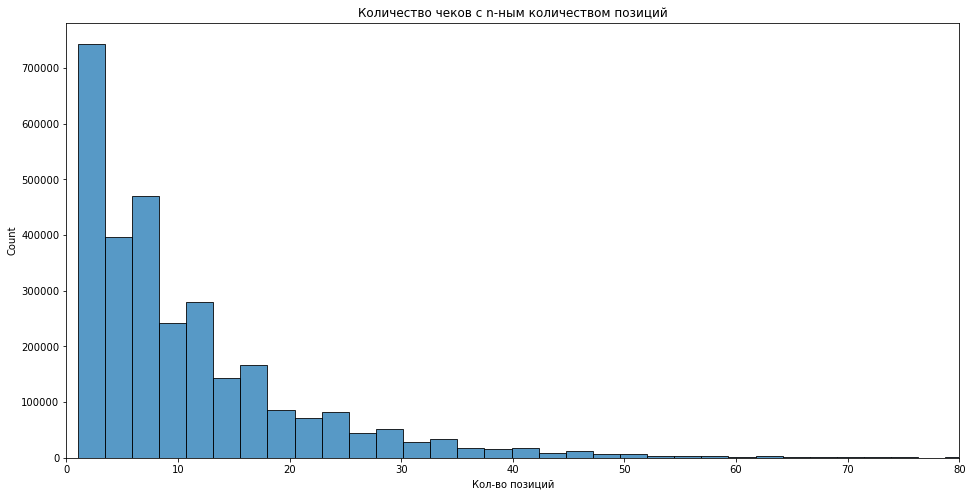

In [10]:
fig = plt.figure()
fig.set_size_inches(16,8)

sns.histplot(agg_by_chq_df['material'], bins=100)

plt.xlim((0, 80))
plt.xlabel('Кол-во позиций')
plt.title('Количество чеков с n-ным количеством позиций')

* Большинство (95%) чеков содержат не больше, чем 30 позиций
* При этом около 38 % чеков содержат не более 5 позиций

In [11]:
(agg_by_chq_df[agg_by_chq_df['material'] <= 5].shape[0] / agg_by_chq_df.shape[0] * 100,
agg_by_chq_df[agg_by_chq_df['material'] <= 30].shape[0] / agg_by_chq_df.shape[0] * 100)

(38.63992539400528, 94.19115311483756)

Посмотрим на общую сумму чеков, распределенную по месяцам. На графике видно, что месяцы с наибольшей суммой продаж - март, апрель, октябрь и декабрь.

Text(0.5, 0, 'Месяц')

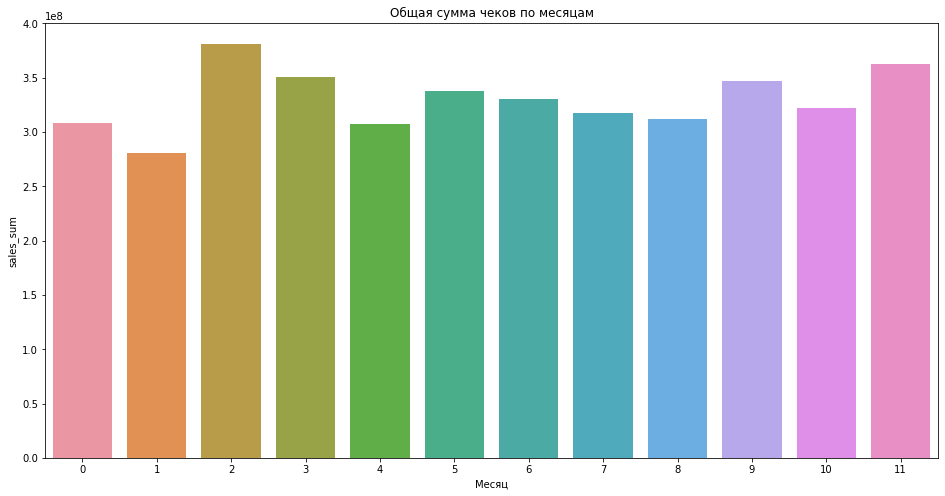

In [12]:
by_month = agg_by_chq_df.groupby(agg_by_chq_df['chq_date'].dt.month, as_index=False)['sales_sum'].sum()

fig = plt.figure()
fig.set_size_inches(16,8)
plt.title('Общая сумма чеков по месяцам')
sns.barplot(x=by_month.index, y=by_month['sales_sum'])
plt.xlabel('Месяц')

График по неделям повторяет график по месяцам, но можно детальнее разглядеть пики - 12, 22, 39 недели. Что соответствует концу марта, началу июня и началу октября. Если бы имелись данные за несколько лет, скорее всего в данных бы прослеживалась сезонность, зависящая от времени года и государтсвенных праздников. 

Text(0.5, 0, 'Номер недели')

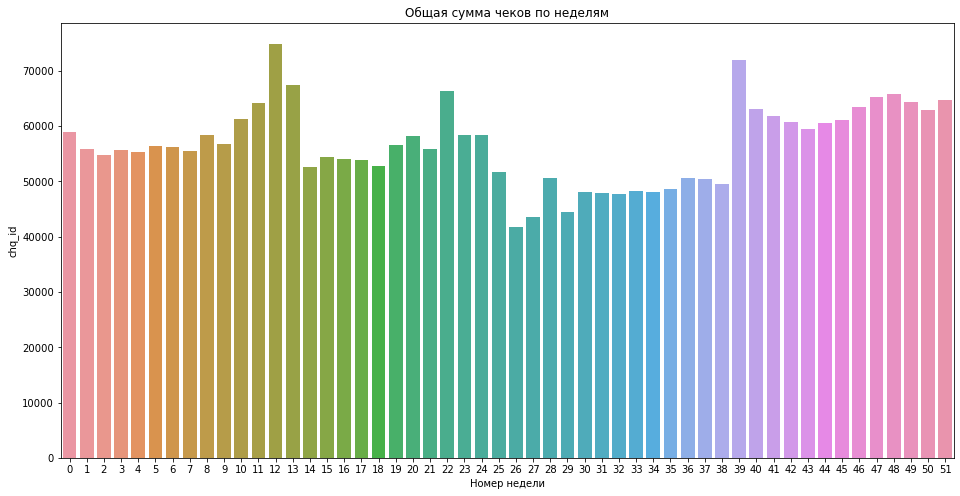

In [13]:
by_week = agg_by_chq_df.groupby(agg_by_chq_df['chq_date'].dt.isocalendar().week, as_index=False)['chq_id'].count()

fig = plt.figure()
fig.set_size_inches(16,8)

sns.barplot(x=by_week.index, y=by_week['chq_id'])
plt.title('Общая сумма чеков по неделям')
plt.xlabel('Номер недели')

Посмотрим на распределение суммы чеков у клиентов разного пола. Чеков у женщин в датасете 58%, незначительно больше чем у мужчин, но их суммы значительно превосходят суммы чеков у мужчин.

In [14]:
agg_by_chq_df['gender'].value_counts(normalize=True)

0.0    0.57823
1.0    0.42177
Name: gender, dtype: float64

Text(0.5, 0, 'Номер недели')

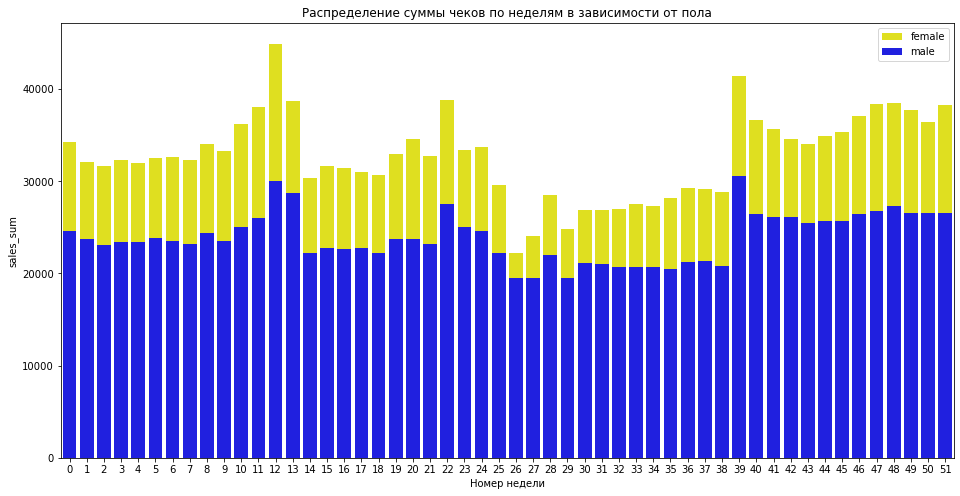

In [15]:
male = agg_by_chq_df[agg_by_chq_df['gender'] == 1]
female = agg_by_chq_df[agg_by_chq_df['gender'] == 0]

by_month_male = male.groupby(male['chq_date'].dt.isocalendar().week, as_index=False)['sales_sum'].count()
by_month_female = female.groupby(female['chq_date'].dt.isocalendar().week, as_index=False)['sales_sum'].count()

fig = plt.figure()
fig.set_size_inches(16,8)

sns.barplot(x=by_month_female.index, y=by_month_female['sales_sum'], label='female', color='Yellow')
sns.barplot(x=by_month_male.index, y=by_month_male['sales_sum'], label='male', color='Blue')

plt.legend()
plt.title('Распределение суммы чеков по неделям в зависимости от пола')
plt.xlabel('Номер недели')

Найдем чеки, в которых город расположения мазагина отличается от типичного города клиента (где он совершает покупки чаще всего).

* Добавим признак foreign_city, который показывает делал ли клиент хоть раз покупку в другом городе
* Около 18% клиентов хоть раз совершали покупки в городе, отличном от типичного города клиента
* Распределение количества чеков таких клиентов не отличается от распределения всех клиентов, поэтому избавляться от них не стоит

In [16]:
agg_by_chq_df['foreign_city'] = (agg_by_chq_df['city_x'] != agg_by_chq_df['city_y']).map(int)

Text(0.5, 0, 'Кол-во чеков')

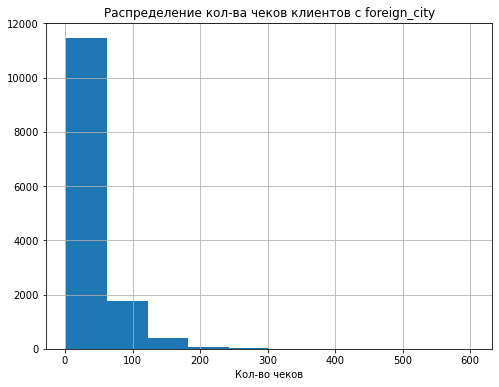

In [17]:
fig = plt.figure()
fig.set_size_inches(8, 6)

foreign_city_clients = agg_by_chq_df[agg_by_chq_df['foreign_city'] == 1]['client_id'].unique()
agg_by_chq_df[agg_by_chq_df['client_id'].isin(foreign_city_clients)].groupby('client_id')['chq_id'].count().hist()

plt.title('Распределение кол-ва чеков клиентов с foreign_city')
plt.xlabel('Кол-во чеков')

Text(0.5, 0, 'Кол-во чеков')

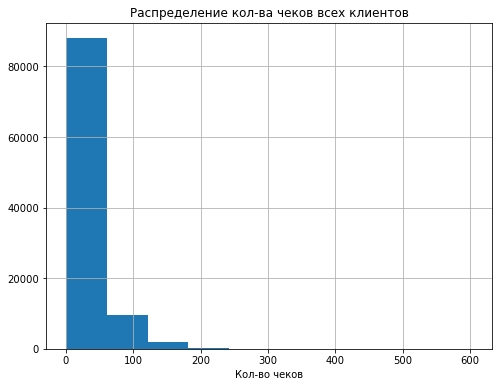

In [18]:
fig = plt.figure()
fig.set_size_inches(8, 6)

agg_by_chq_df.groupby('client_id')['chq_id'].count().hist()
foreign_city_clients.shape[0] / agg_by_chq_df['client_id'].nunique()

plt.title('Распределение кол-ва чеков всех клиентов')
plt.xlabel('Кол-во чеков')

In [19]:
#удалим признак города магазина, т.к. добавили признак foreign_city

agg_by_chq_df = agg_by_chq_df.drop('city_y', axis=1).rename({'city_x' : 'city'}, axis=1)

Проанализируем распределение возраста клиентов.

На графике видно, что есть клиенты установившие себе год рождения <1916 года, на момент сбора данных им должно быть около 100 лет, также есть клиенты с годом рождения >2006. Скорее всего, такие данные были внесены пользователем неверно и от них лучше избавиться для того чтобы не путать модель. 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение года рождения клиентов')

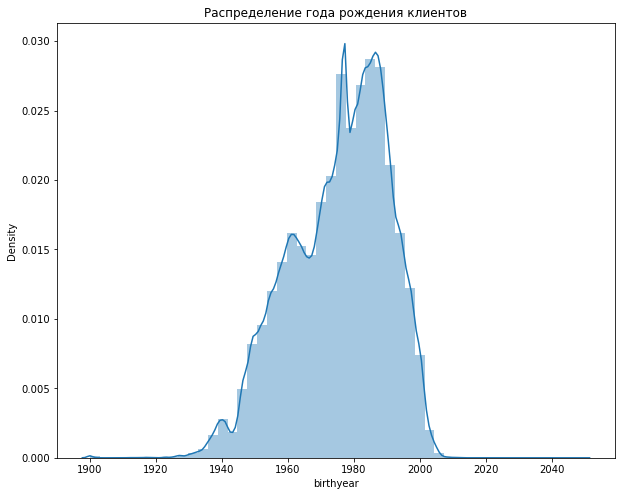

In [20]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.distplot(agg_by_chq_df['birthyear'])
plt.title('Распределение года рождения клиентов')

In [21]:
#удаляем клиентов, которым больше 100 лет и меньше 10

agg_by_chq_df = agg_by_chq_df[(agg_by_chq_df['birthyear'] >= 1916) & (agg_by_chq_df['birthyear'] <= 2006)] 

Разделим клиентов на 6 групп по возрасту, чтобы посмотреть на распределение суммы чеков внутри этих групп.

1. Год рождения 1920 и меньше
1. Год рождения с 1920 по 1940
1. Год рождения с 1940 по 1960
1. Год рождения с 1960 по 1980
1. Год рождения с 1980 по 2000
1. Год рождения 2000 и больше

**Из графика можно сделать вывод, что наибольшие суммы чеков у людей в группе с возрастом от 35 до 56 лет, наименьшие - в группе в возрасте 16 лет и младше**

Text(0, 0.5, 'Сумма чеков')

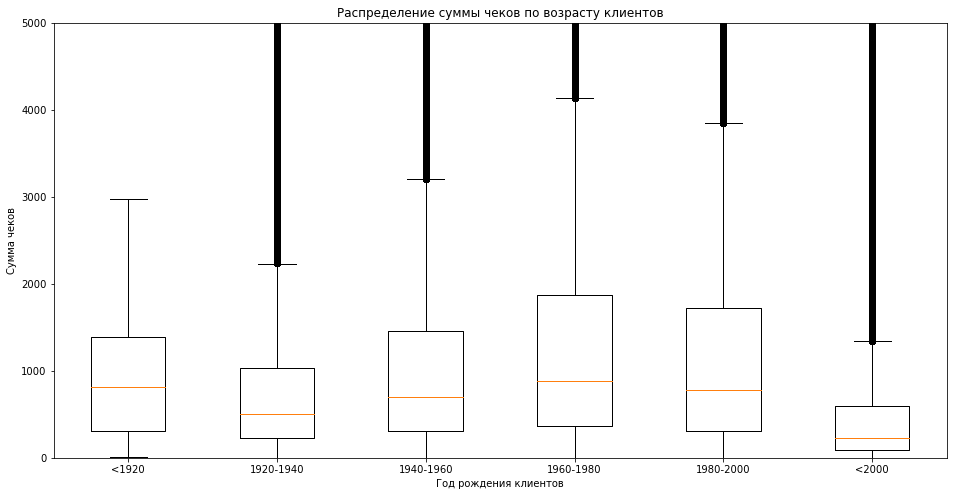

In [22]:
fig = plt.figure()
fig.set_size_inches(16, 8)

birth_1920 = agg_by_chq_df[agg_by_chq_df['birthyear'] <= 1920]
birth1920_40 = agg_by_chq_df[(agg_by_chq_df['birthyear'] > 1920) & (agg_by_chq_df['birthyear'] <= 1940)]
birth1940_60 = agg_by_chq_df[(agg_by_chq_df['birthyear'] > 1940) & (agg_by_chq_df['birthyear'] <= 1960)]
birth1960_80 = agg_by_chq_df[(agg_by_chq_df['birthyear'] > 1960) & (agg_by_chq_df['birthyear'] <= 1980)]
birth1980_00 = agg_by_chq_df[(agg_by_chq_df['birthyear'] > 1980) & (agg_by_chq_df['birthyear'] <= 2000)]
birth2000_ = agg_by_chq_df[agg_by_chq_df['birthyear'] >= 2000]

plt.boxplot([birth_1920['sales_sum'], birth1920_40['sales_sum'], birth1940_60['sales_sum'], birth1960_80['sales_sum'],
             birth1980_00['sales_sum'], birth2000_['sales_sum']], 
           labels=('<1920', '1920-1940', '1940-1960', '1960-1980', '1980-2000', '<2000'))

plt.ylim((0,5000))
plt.title('Распределение суммы чеков по возрасту клиентов')
plt.xlabel('Год рождения клиентов')
plt.ylabel('Сумма чеков')

Разделим клиентов на группы по городу, в котором они чаще всего совершали покупки.

**В данных представлено 78% клиентов из других городов, и всего 16% и 5% из Санкт-Петербурга и Москвы соответственно.**

In [23]:
agg_by_chq_df['city'].value_counts(normalize=True)

Other             0.780999
St. Petersburg    0.164696
Moscow            0.054305
Name: city, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Кол-во чеков в разных городах')

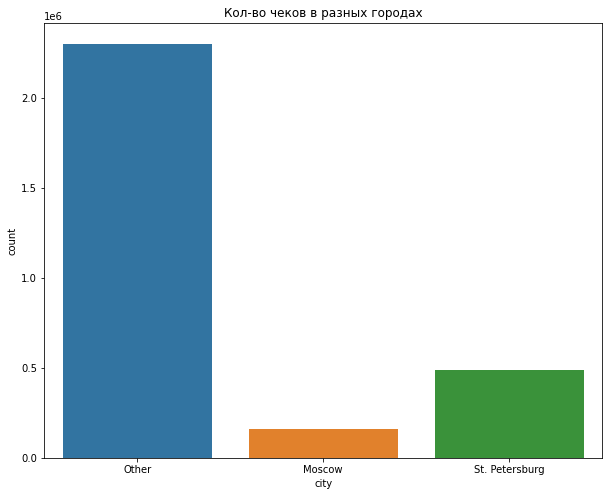

In [24]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.countplot(agg_by_chq_df['city'])
plt.title('Кол-во чеков в разных городах')

**Медианная сумма чеков в Санкт-Петербурге больше, чем в остальных городах,** распределение больше вытянуто в сторону увеличения суммы чеков. 

**Суммы чеков Москвы и других городов (кроме Санкт-Петербурга) значительно не отличаются.**

Text(0.5, 1.0, 'Распределение суммы чека в разных городах')

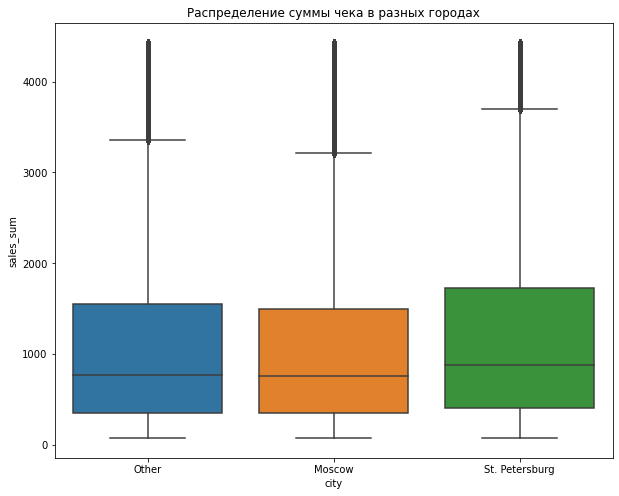

In [25]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.boxplot(
    data=agg_by_chq_df[(agg_by_chq_df['sales_sum'] >= agg_by_chq_df['sales_sum'].quantile(0.05)) & 
              (agg_by_chq_df['sales_sum'] <= agg_by_chq_df['sales_sum'].quantile(0.95))],
    x='city', y='sales_sum')
plt.title('Распределение суммы чека в разных городах')

Посмотрим на разницу в сумме чека между супермаркетами и гипермаркетами.

**Медианная сумма чека в гипермаркете более чем в 2 раза превосходит медианный чек в супермаркете.**

In [26]:
print('Медианный чек в супермаркете  -', agg_by_chq_df[agg_by_chq_df['plant_type'] == 'SM']['sales_sum'].median())
print('Медианный чек в гипермаркете  -',agg_by_chq_df[agg_by_chq_df['plant_type'] == 'HM']['sales_sum'].median())

Медианный чек в супермаркете  - 407.0
Медианный чек в гипермаркете  - 900.0


Text(0.5, 1.0, 'Распределение суммы чека в магазинах разных типов')

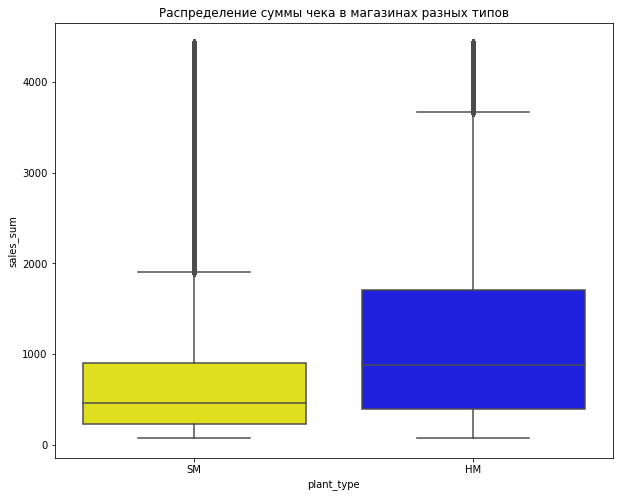

In [27]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.boxplot(
    data=agg_by_chq_df[(agg_by_chq_df['sales_sum'] >= agg_by_chq_df['sales_sum'].quantile(0.05)) & 
              (agg_by_chq_df['sales_sum'] <= agg_by_chq_df['sales_sum'].quantile(0.95))],
    x='plant_type', y='sales_sum', palette=['yellow', 'blue'])

plt.title('Распределение суммы чека в магазинах разных типов')

In [28]:
agg_by_chq_df['plant_type'] = agg_by_chq_df['plant_type'].map({'HM' : 1, 'SM' : 0})

In [29]:
agg_by_chq_df.groupby('plant_type',as_index=False)['chq_id'].count()

,plant_type,chq_id
0,0,467076
1,1,2481019


Посмотрим на среднюю сумму чека в зависимости от rate-признаков, таких как is_promo_rate, is_private_label_rate, is_alco_rate, hair_level_1_rate.

**- Средняя сумма чеков, содержащих алкогольную продукцию, часто больше остальных средних чеков.**

**- Чем больше в чеке товаров собственной марки, тем меньше в среднем сумма чека.**

(0.0, 1.0)

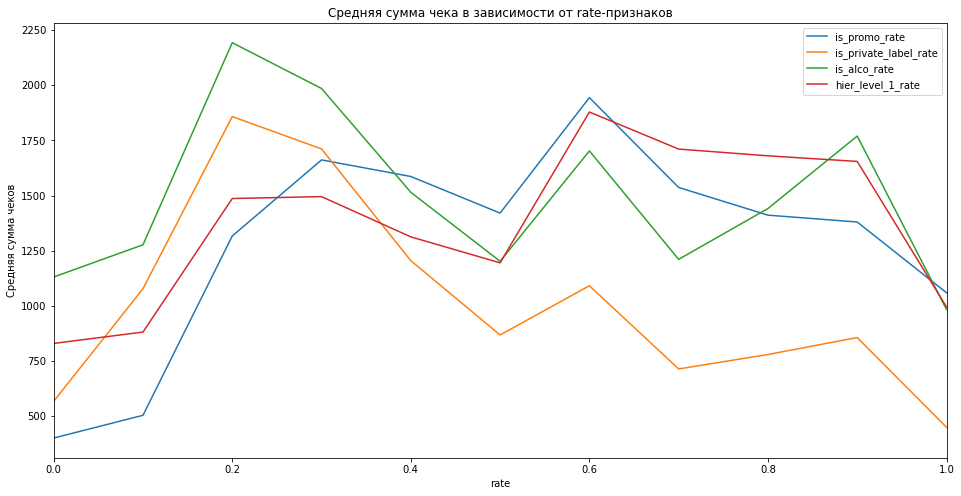

In [30]:
fig = plt.figure()
fig.set_size_inches(16, 8)

d = {x : 0 for x in np.arange(0, 1.1, .1)}

for x in d.keys():
    
    d[x] = agg_by_chq_df[(agg_by_chq_df['is_promo_rate'] <= x) & (agg_by_chq_df['is_promo_rate'] >= x - 0.1)] \
    ['sales_sum'].mean()
    
sns.lineplot(x=d.keys(), y=d.values(), label='is_promo_rate')

d = {x : 0 for x in np.arange(0, 1.1, .1)}

for x in d.keys():
    
    d[x] = agg_by_chq_df[(agg_by_chq_df['is_private_label_rate'] <= x) & (agg_by_chq_df['is_private_label_rate'] >= x - 0.1)] \
    ['sales_sum'].mean()
    
sns.lineplot(x=d.keys(), y=d.values(), label='is_private_label_rate')

d = {x : 0 for x in np.arange(0, 1.1, .1)}

for x in d.keys():
    
    d[x] = agg_by_chq_df[(agg_by_chq_df['is_alco_rate'] <= x) & (agg_by_chq_df['is_alco_rate'] >= x - 0.1)] \
    ['sales_sum'].mean()
    
sns.lineplot(x=d.keys(), y=d.values(), label='is_alco_rate')


d = {x : 0 for x in np.arange(0, 1.1, .1)}

for x in d.keys():
    
    d[x] = agg_by_chq_df[(agg_by_chq_df['hier_level_1_rate'] <= x) & (agg_by_chq_df['hier_level_1_rate'] >= x - 0.1)] \
    ['sales_sum'].mean()
    
sns.lineplot(x=d.keys(), y=d.values(), label='hier_level_1_rate')

plt.title('Средняя сумма чека в зависимости от rate-признаков')
plt.xlabel('rate')
plt.ylabel('Средняя сумма чеков')
plt.xlim((0, 1))

Проанализируем datediff - скользящую разницу между заказами клиента в днях. Распределение похоже на логнормальное, но с большим количеством выбросов справа 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Распределение разницы между чеками для каждого клиента в днях')

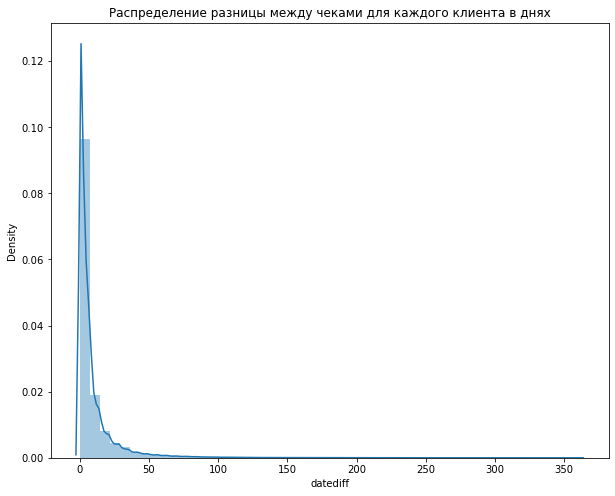

In [31]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.distplot(agg_by_chq_df['datediff'])
plt.title('Распределение разницы между чеками для каждого клиента в днях')

Большая разница между средним промежутком и медианным обусловлена большим кол-вом выбросов

In [32]:
print('Средний промежуток между чеками -', agg_by_chq_df['datediff'].mean(), 'дней')
print('Медианный промежуток между чеками -', agg_by_chq_df['datediff'].median(), 'дней')

Средний промежуток между чеками - 9.437974352929604 дней
Медианный промежуток между чеками - 4.0 дней


95% клиентов имеют разницу между чеками больше, чем в 38 дней.

**Т.е. 95% клиентов совершают покупку минимум раз в месяц или чаще.**

In [33]:
agg_by_chq_df['datediff'].quantile(0.95)

38.0

## Выводы после EDA

1. **В выборке есть чеки с отрицательной суммой.** Скорее всего это **возвраты.**
1. **Средняя сумма чека в выборке - 1341, медианнная - 790.** Среднее чувствительно к выбросам, которых в выборке очень много, особенно больших
1. **Большинство (95%) чеков содержат менее 30 позиций**
1. **Месяцы с наибольшей суммой продаж - март, апрель, октябрь, декабрь**
1. **В большинстве случаем суммы чеков женщин больше**, чем суммы чеков мужчин
1. **Около 18% клиентов хоть раз совершали покупку в другом городе**
1. **Наибольшая средняя сумма чека - в возрастной группе от 35 до 56 лет**, наименьшая - в возрастной группе 16 и младше
1. **Медианная сумма чеков наибольшая в Санкт-Петербурге**
1. **Медианный чек в гипермаркетах превосходит медианный чек в супермаркетах** больше чем в 2 раза
1. **Чеки, содержащие алкогольную продукцию, в среднем имеют большую сумму**, а чеки, содержащие privat_label - меньшую
1. **95% клиентов из выборки совершают покупку хотя бы раз в месяц или чаще**

# 2. Создание таргетной переменной и подготовка данных к обучению

Разделим данные на две части по времеменному принципу - тренировочная часть - с 4 октября 2016 по 4 августа 2017 (10 месяцев), тестовая часть - с 5 августа по 4 октября 2017 года (2 месяца). 

**Таким образом мы сможем пометить ушедшими тех клиентов, которые делали покупки за 10 месяцев трейнового периода, но отсутствуют двухмесячном тестовом.**

In [34]:
test = agg_by_chq_df[(agg_by_chq_df['chq_date'] <= '2017-10-04') & (agg_by_chq_df['chq_date'] >= '2017-08-04')]
train = agg_by_chq_df[agg_by_chq_df['chq_date'] < '2017-08-04']

test.shape[0] / train.shape[0] * 100

17.248262411291105

Аггрегируем данные чеков по клиентам. Для обучения модели нам нужна будет одна строка на одного клиента.

In [35]:
def aggregate_df_by_clients(agg_by_chq_df):
    
    #аггрегируем по клиентам
    agg_by_clients_df = agg_by_chq_df.groupby('client_id', as_index=False).agg({'chq_id' : 'count',
                                                     'material' : 'sum',
                                                     'chq_date' : 'max', 
                                                     'datediff' : ['mean', 'max'],
                                                     'sales_sum' : 'mean',
                                                     'is_promo_rate' : 'mean',
                                                     'hier_level_1_rate' : 'mean',
                                                     'is_private_label_rate' : 'mean', 
                                                     'is_alco_rate' : 'mean',
                                                     'city' : 'max',
                                                     'gender' : 'max',
                                                     'birthyear' : 'max',
                                                     'plant_type' : 'mean',
                                                     'foreign_city' : 'mean'
                                                    })
    
    agg_by_clients_df.columns = agg_by_clients_df.columns.map('_'.join)
    
    #создадим признак - количество дней с последней транзакции клиента
    agg_by_clients_df['days_from_last_transaction'] = (agg_by_clients_df['chq_date_max'].max() - agg_by_clients_df['chq_date_max']).dt.days
    
    agg_by_clients_df = agg_by_clients_df.drop(['material_sum', 'chq_date_max'],axis=1)
    
    agg_by_clients_df.rename({'client_id_' : 'client_id', 'city_max' : 'city', 'gender_max': 'gender',
                              'birthyear_max' : 'birthyear', 'plant_type_mean' : 'plant_type_HM_rate',
                             'foreign_city_mean' : 'foreign_city_rate'},
                             axis=1, inplace=True)
    
    agg_by_clients_df[['datediff_mean','datediff_max']].fillna(0, inplace=True)
    
    return agg_by_clients_df

In [36]:
#создаем аггрегориванные по клиентам трейн и тест датасеты

train_agg_df = aggregate_df_by_clients(train)
test_agg_df = aggregate_df_by_clients(test)

C:\Users\user\AppData\Local\Temp\ipykernel_3356\710749791.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_by_clients_df[['datediff_mean','datediff_max']].fillna(0, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_3356\710749791.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_by_clients_df[['datediff_mean','datediff_max']].fillna(0, inplace=True)


In [37]:
train_agg_df.head()

,client_id,chq_id_count,datediff_mean,datediff_max,sales_sum_mean,is_promo_rate_mean,hier_level_1_rate_mean,is_private_label_rate_mean,is_alco_rate_mean,city,gender,birthyear,plant_type_HM_rate,foreign_city_rate,days_from_last_transaction
0,0000d48a8891cd462fdf01ea861ec53e,36,7.527778,20.0,2125.138889,0.464495,0.850783,0.187575,0.005587,St. Petersburg,1.0,1958.0,1.000000,0.0,5
1,00028a1dcb30863404a386961a69300e,26,11.307692,50.0,1793.076923,0.343621,0.846920,0.253900,0.061100,Other,1.0,1972.0,1.000000,0.0,4
2,0004274683494a9eca5e70ef97299d55,146,2.047945,12.0,561.273973,0.399469,0.935828,0.424947,0.018180,St. Petersburg,1.0,1975.0,0.356164,0.0,4
3,00072f81efcb3481861f7300c5e2a88a,7,30.857143,69.0,473.285714,0.418677,0.530612,0.393321,0.000000,Other,1.0,1952.0,1.000000,0.0,62
4,00076596eb749cf10c2e984621dffe95,137,2.197080,35.0,1227.094891,0.482735,0.821346,0.252018,0.028338,Other,0.0,1989.0,1.000000,0.0,1


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Распределение кол-ва дней, прошедших с последней транзакции')

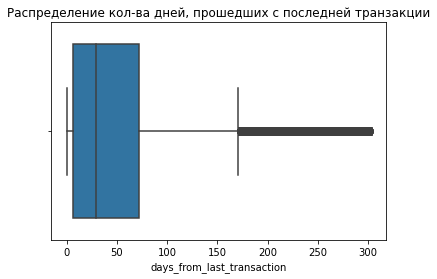

In [38]:
sns.boxplot(train_agg_df['days_from_last_transaction'])
plt.title('Распределение кол-ва дней, прошедших с последней транзакции')

In [39]:
train_agg_df['days_from_last_transaction'].describe()

count    99930.000000
mean        56.605784
std         72.175013
min          0.000000
25%          6.000000
50%         29.000000
75%         72.000000
max        303.000000
Name: days_from_last_transaction, dtype: float64

In [40]:
#проставим таргетную переменную

train_agg_df['churn'] = train_agg_df['client_id'].isin(test_agg_df['client_id']).apply(lambda x: 0 if x is True else 1)

Построим распределение дней с последней транзакции в зависимости от таргетной переменной churn.

**Начиная с 67 дней количество пользователей, которые ушли, начинает перевешивать количество пользователей, которые остались. Таким образом, пользователи, которые не совершали покупок в течение 67 и больше, могут считаться склонными к оттоку. Тоже самое видно и на scatterplot**

Text(0.5, 1.0, 'Распределение оставшихся/ушедших клиентов по кол-ву дней с последней транзакции')

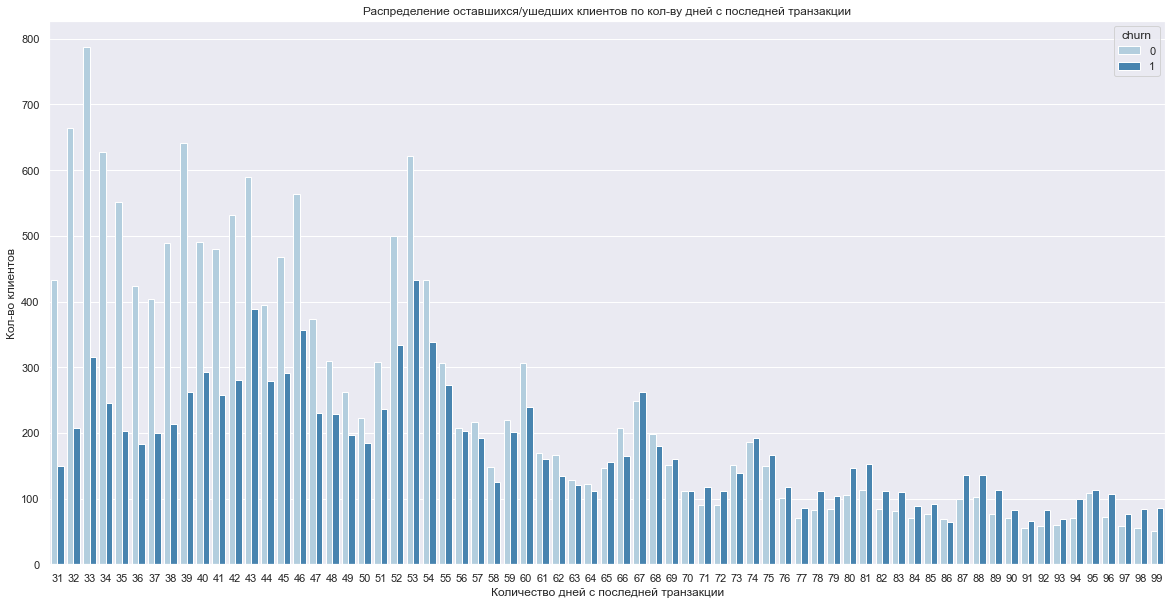

In [47]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.countplot(
    x='days_from_last_transaction',
    hue='churn',
    data=train_agg_df[(train_agg_df['days_from_last_transaction'] > 30) &
                 (train_agg_df['days_from_last_transaction'] < 100)],
    palette='Blues'
)
plt.xlabel('Количество дней с последней транзакции')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение оставшихся/ушедших клиентов по кол-ву дней с последней транзакции')

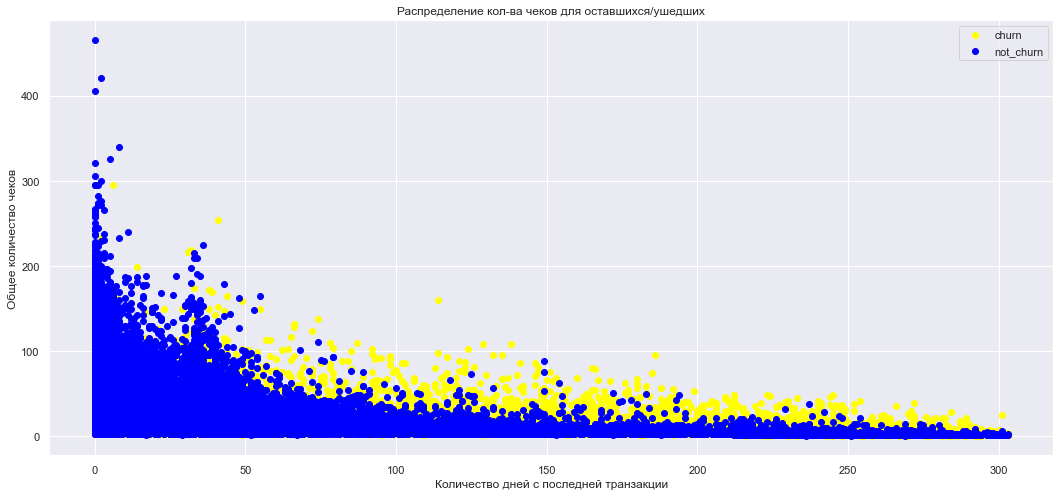

In [42]:
plt.scatter(train_agg_df[train_agg_df['churn'] == 1]['days_from_last_transaction'], 
            train_agg_df[train_agg_df['churn'] == 1]['chq_id_count'],
           color='yellow', label='churn')
plt.scatter(train_agg_df[train_agg_df['churn'] == 0]['days_from_last_transaction'], 
            train_agg_df[train_agg_df['churn'] == 0]['chq_id_count'],
           color='blue', label='not_churn')
plt.xlabel('Количество дней с последней транзакции')
plt.ylabel('Общее количество чеков')
plt.title('Распределение кол-ва чеков для оставшихся/ушедших')
plt.legend()

Посмотрим на распределение ушедних клиентов в разных группах

* В Москве процент ушедших клиентов максимальный, хотя на это может влиять малое кол-во данных о транзакциях в московских магазинах

* Процент ушедших клиентов не отличается среди мужчин и женщин

* Процент ушедших пользователей в группах старше 75 и младше 16 больше, чем в группах другого возраста, на это также может влиять малое кол-во данных в таких группах

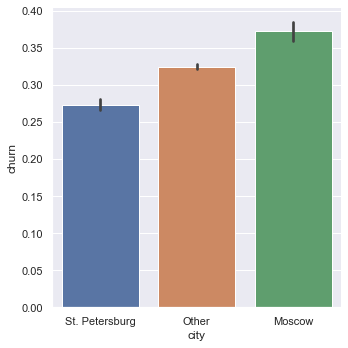

In [48]:
sns.catplot(kind='bar', x='city', y='churn', data=train_agg_df)

In [49]:
train_agg_df['city'].value_counts()

Other             81164
St. Petersburg    13356
Moscow             5410
Name: city, dtype: int64

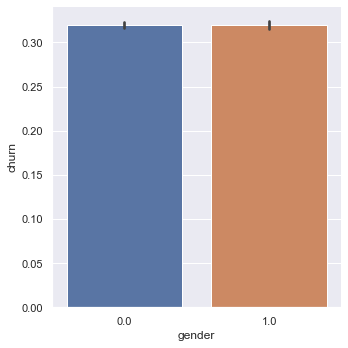

In [50]:
sns.catplot(kind='bar', x='gender', y='churn', data=train_agg_df)

<AxesSubplot:xlabel='birthyear', ylabel='churn'>

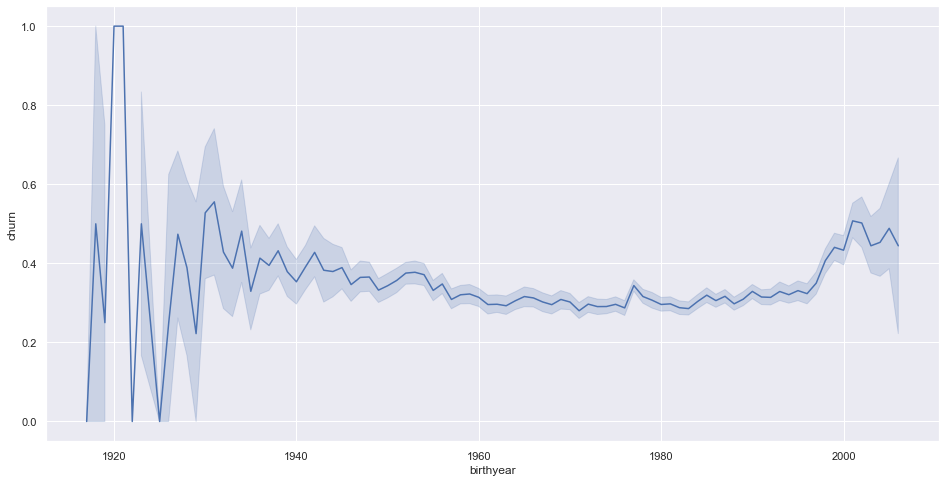

In [51]:
fig = plt.figure()
fig.set_size_inches(16, 8)

sns.lineplot(x='birthyear', y='churn', data=train_agg_df)

In [52]:
train_agg_df['churn'].value_counts(normalize=True)

0    0.680026
1    0.319974
Name: churn, dtype: float64

In [53]:
train_agg_df[train_agg_df['birthyear'] < 1940]['churn'].value_counts(normalize=True)

0    0.594102
1    0.405898
Name: churn, dtype: float64

In [54]:
train_agg_df[train_agg_df['birthyear'] > 2000]['churn'].value_counts(normalize=True)

0    0.512775
1    0.487225
Name: churn, dtype: float64

Построим матрицу корреляций признаков между собой и с таргетом

* Таргетная переменная больше всего коррелирует с средней разницей между транзакциями, кол-вом дней с последней транзакции, отрицательно коррелирует с кол-вом чеков

* Процент транзакций в гипермаркетах коррелирует с средней суммой чека

* Количество чеков коррелирует с процентом купленных товаров из категории еда (hier_level_1_rate)

In [55]:
cat_cols = train_agg_df.loc[:, train_agg_df.dtypes == np.object].columns
num_cols = train_agg_df.loc[:, train_agg_df.dtypes != np.object].columns

C:\Users\user\AppData\Local\Temp\ipykernel_3356\3741312199.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_cols = train_agg_df.loc[:, train_agg_df.dtypes == np.object].columns
C:\Users\user\AppData\Local\Temp\ipykernel_3356\3741312199.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_cols = train_agg_df.loc[:, train_agg_df.dtypes != np.object].columns


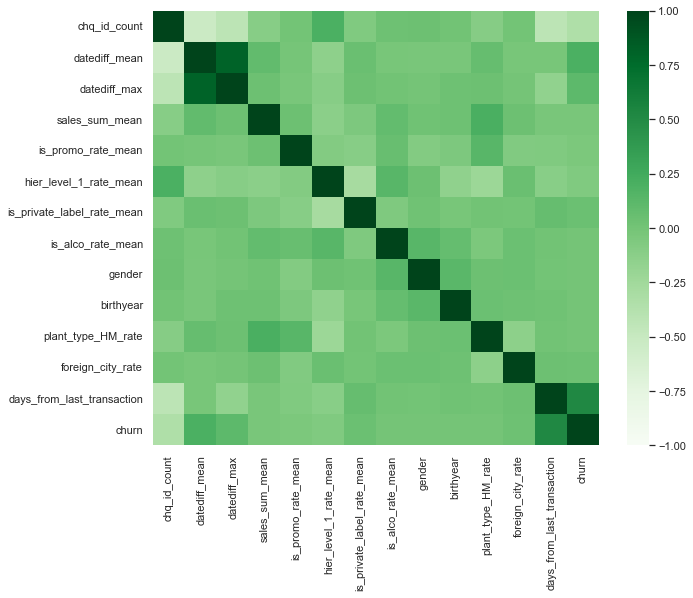

In [56]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.heatmap(train_agg_df[num_cols].corr(),cmap='Greens', vmin=-1,
            vmax=1)

plt.show()

In [57]:
#Закодируем признак города через Ohe-hot encoding

ohe = pd.get_dummies(train_agg_df['city'], drop_first=True, prefix='city')
train_agg_df = pd.concat((train_agg_df.drop('city', axis=1), ohe), axis=1)

Выраженного дисбаланса классов в трейн выборке не обнаружено

In [58]:
train_agg_df['churn'].value_counts(normalize=True)

0    0.680026
1    0.319974
Name: churn, dtype: float64

# 3. Обучение и интерпретация моделей

Обучим несколько моделей, которые имеют возможность предсказывать вероятности

1. Логистическая регрессия с l1-регуляризацией
1. Random Forest
1. Градиентный бустинг catboost

In [59]:
#разделим данные на тренировочную и тестовую часть

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc
X = train_agg_df.drop(['client_id', 'churn'], axis=1)
y = train_agg_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [60]:
#обучим катбуст на дефолтных параметрах, максимизируя AUC

from catboost import CatBoostClassifier

classifier = CatBoostClassifier(
    custom_loss=['AUC'],
    random_seed=42,
    logging_level='Silent')

classifier.fit(X_train, y_train)

In [61]:
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     13578
           1       0.70      0.62      0.66      6408

    accuracy                           0.79     19986
   macro avg       0.76      0.75      0.75     19986
weighted avg       0.79      0.79      0.79     19986



Получили accuracy - 0.79 и f-score по положительному классу - 0.66 

Построим ROC-кривую и посчитаем AUC

0.857057659550249

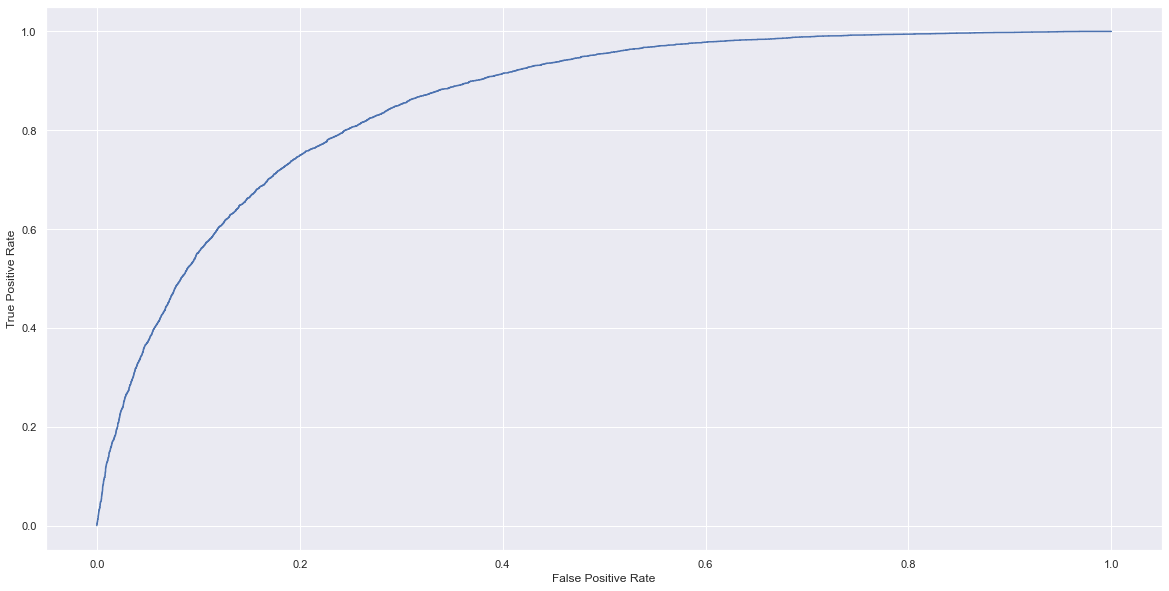

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc(fpr, tpr)

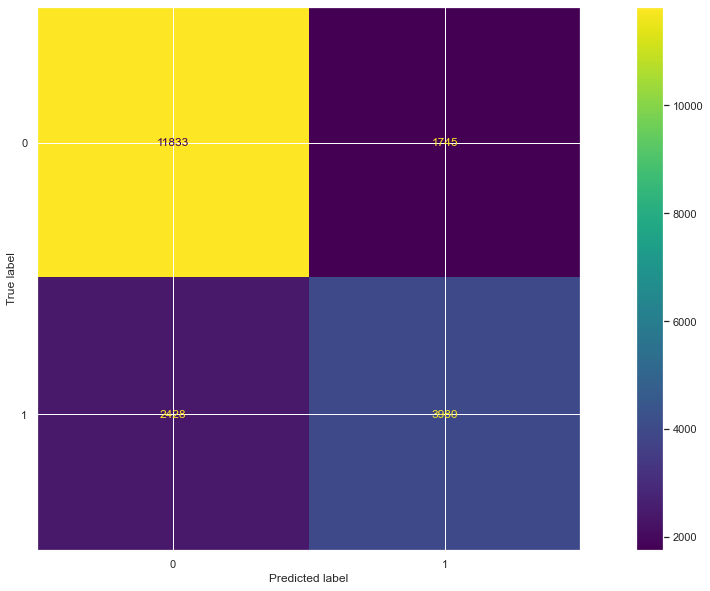

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, classifier.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [88]:
print('Модель GradientBoost правильно разметила', abs(1747 / 3972 - 1)*100, '% ушедших клиентов')
print('Модель GradientBoost правильно разметила', abs(2436 / 11831 - 1)*100, '% оставшихся клиентов')

Модель GradientBoost правильно разметила 56.0171198388721 % ушедших клиентов
Модель GradientBoost правильно разметила 79.41002451187558 % оставшихся клиентов


Text(0.5, 1.0, 'GradientBoost')

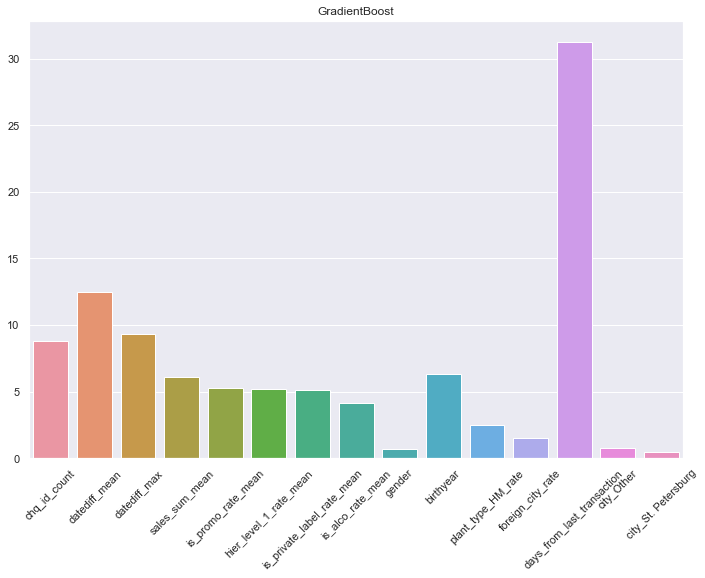

In [65]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.barplot(y=classifier.feature_importances_, x=X.columns)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('GradientBoost')

В качестве значимых модель выделила признаки - количество дней с последнего заказа, среднее и максимальное кол-во дней между заказами и кол-во чеков у клиента. Такой результат вполне ожидаем.

Проверим, можно ли корректно интерпретировать вероятности. Для этого построим калибровочную кривую модели и кривую модели, которая идеально отображает вероятности классов. **Из графика видно, что catboost предсказывает довольно точные вероятности, т.к. кривая модели находится очень близко к кривой идеальной модели.**

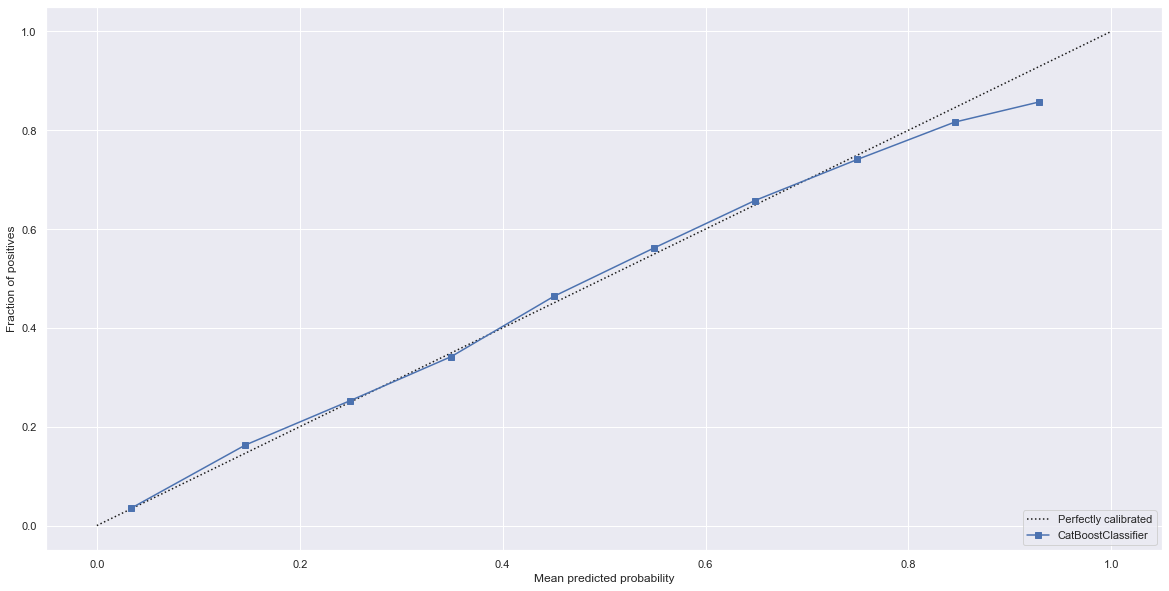

In [66]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(classifier, X_test, y_test, n_bins=10)


Посмотрим на тех клиентов, относительно которых модель дает неуверенный прогноз (вероятность около ~0.5) и уверенный прогноз принадлежности к оттоку

In [67]:
X_train_probas = X_train.copy()

X_train_probas['pred'] = classifier.predict_proba(X_train)[:, 1]

unsure_probas = X_train_probas[(X_train_probas['pred'] >= 0.45) & (X_train_probas['pred'] <= 0.55)]
sure_probas = X_train_probas[X_train_probas['pred'] >= 0.80]

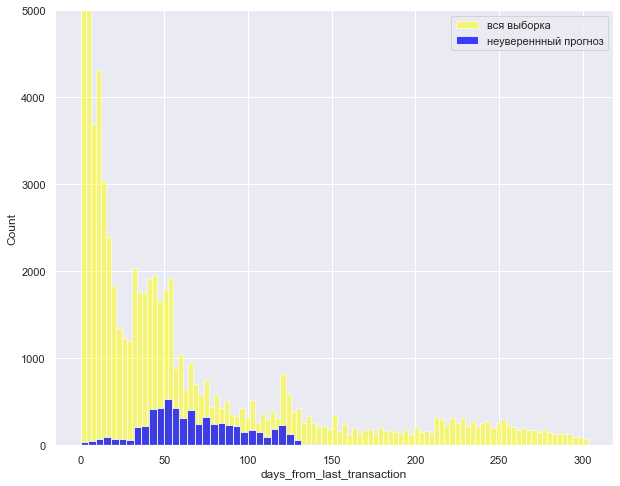

In [68]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.histplot(X_train['days_from_last_transaction'], alpha=0.5, color='yellow', label='вся выборка'),
sns.histplot(unsure_probas['days_from_last_transaction'], color='blue', label='неувереннный прогноз')

plt.ylim((0,5000))
plt.legend()

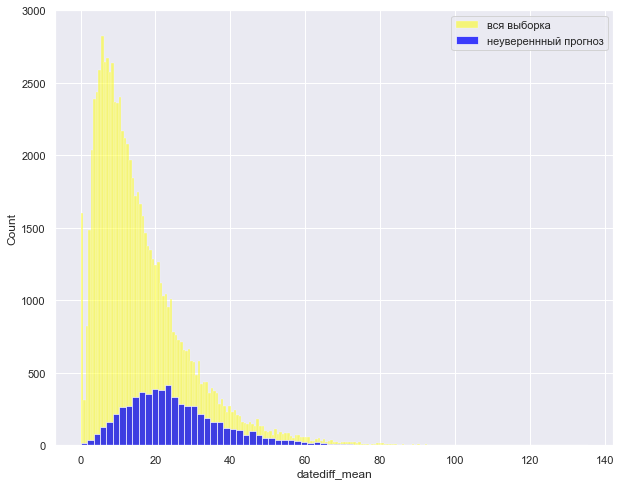

In [69]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.histplot(X_train['datediff_mean'], alpha=0.5, color='yellow', label='вся выборка'),
sns.histplot(unsure_probas['datediff_mean'], color='blue', label='неувереннный прогноз')

plt.ylim((0,3000))
plt.legend()

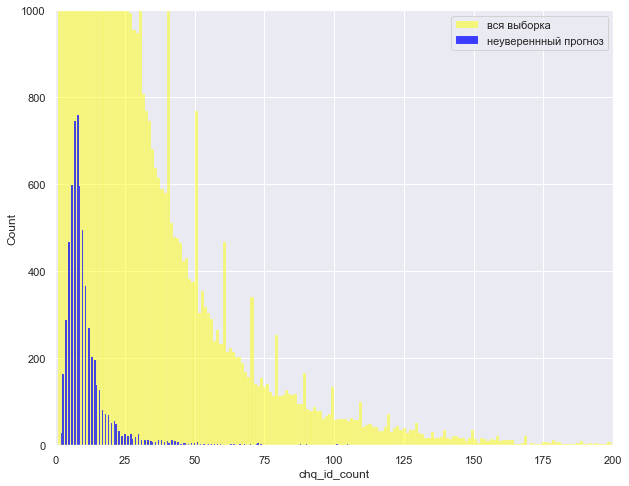

In [70]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.histplot(X_train['chq_id_count'], alpha=0.5, color='yellow', label='вся выборка'),
sns.histplot(unsure_probas['chq_id_count'], color='blue', label='неувереннный прогноз')

plt.ylim((0,1000))
plt.xlim((0,200))
plt.legend()

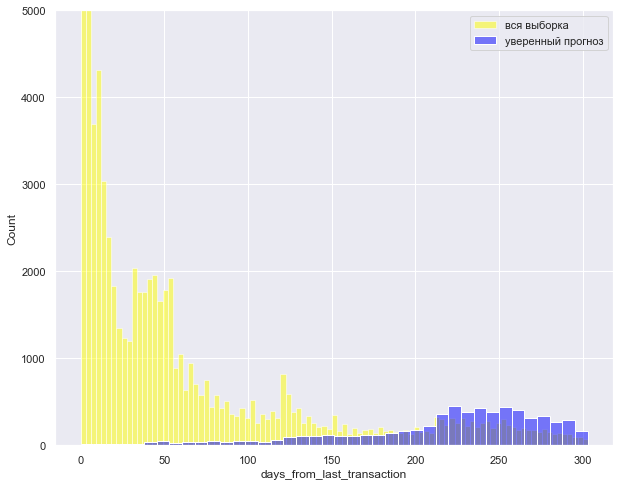

In [71]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.histplot(X_train['days_from_last_transaction'], alpha=0.5, color='yellow', label='вся выборка'),
sns.histplot(sure_probas['days_from_last_transaction'], color='blue',  alpha=0.5, label='уверенный прогноз')

plt.ylim((0,5000))
plt.legend()

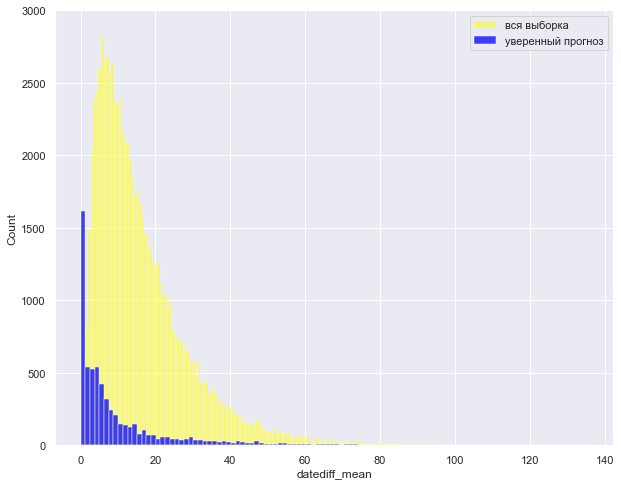

In [72]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.histplot(X_train['datediff_mean'], alpha=0.5, color='yellow', label='вся выборка'),
sns.histplot(sure_probas['datediff_mean'], color='blue', label='уверенный прогноз')

plt.ylim((0,3000))
plt.legend()

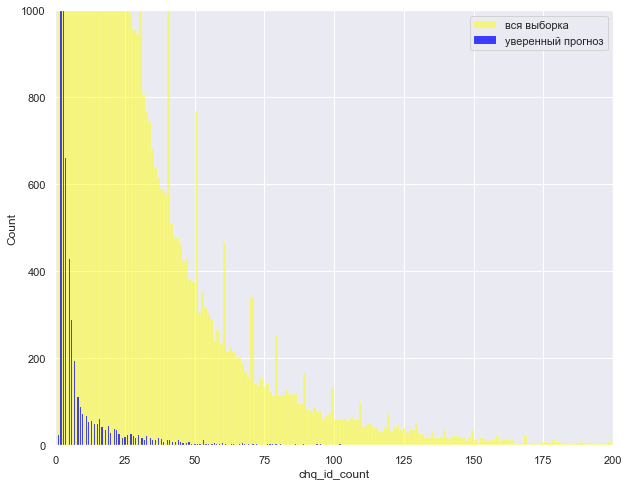

In [73]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.histplot(X_train['chq_id_count'], alpha=0.5, color='yellow', label='вся выборка'),
sns.histplot(sure_probas['chq_id_count'], color='blue', label='уверенный прогноз')

plt.ylim((0,1000))
plt.xlim((0,200))
plt.legend()

* **Модель дает неуверенный прогноз (вероятность ~ 0.5) для клиентов, у которых количество дней с последней транзакции находится в промежутке от 30 до 100. 4**

* **Модель достаточно уверена(вероятность < 0.8), что клиент ушел в отток, если количество дней с последней транзакции больше 100**

* **Модель достаточно уверена, что клиент ушел в отток, если средняя разница между его чеками равна 0. Т.е. у клиента был всего один заказ.**

### Logistic Regression, Random Forest

Построим модели логистической регрессии и случайного леса с дефолтными параметрами и посмотрим на результаты классификации

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipe_LR = Pipeline([('scaler', StandardScaler()), ('LogReg', LogisticRegression(penalty='l1', solver='saga'))])
RF = RandomForestClassifier()

pipe_LR.fit(X_train, y_train)
RF.fit(X_train, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     13578
           1       0.72      0.52      0.61      6408

    accuracy                           0.78     19986
   macro avg       0.76      0.71      0.73     19986
weighted avg       0.77      0.78      0.77     19986



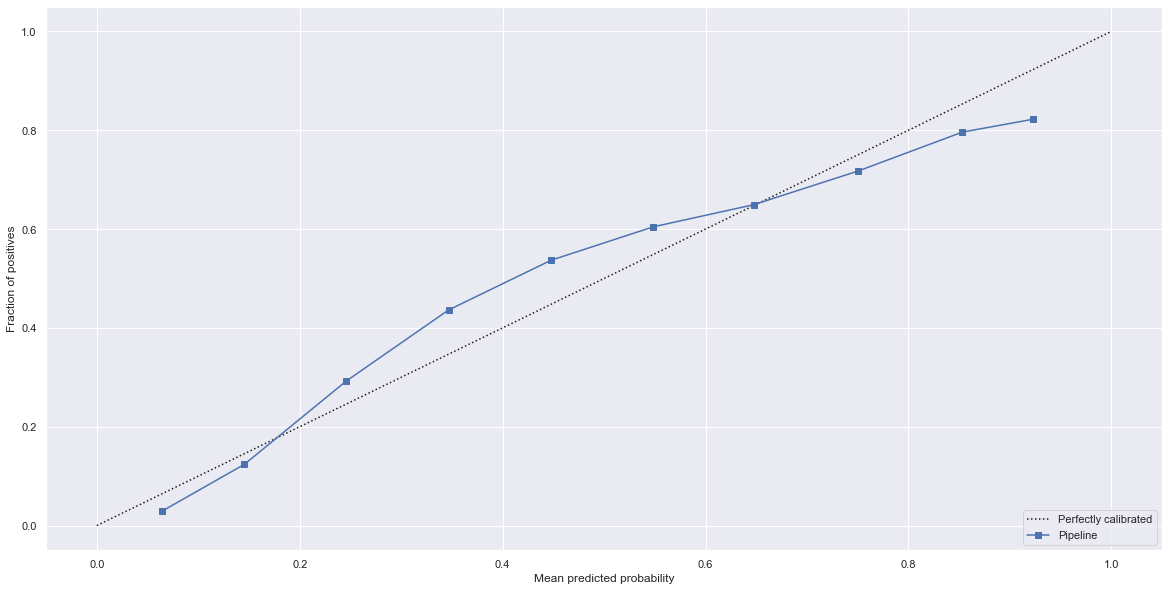

In [77]:
print(classification_report(y_test, pipe_LR.predict(X_test)))

CalibrationDisplay.from_estimator(pipe_LR, X_test, y_test, n_bins=10)

0.8457911670104519

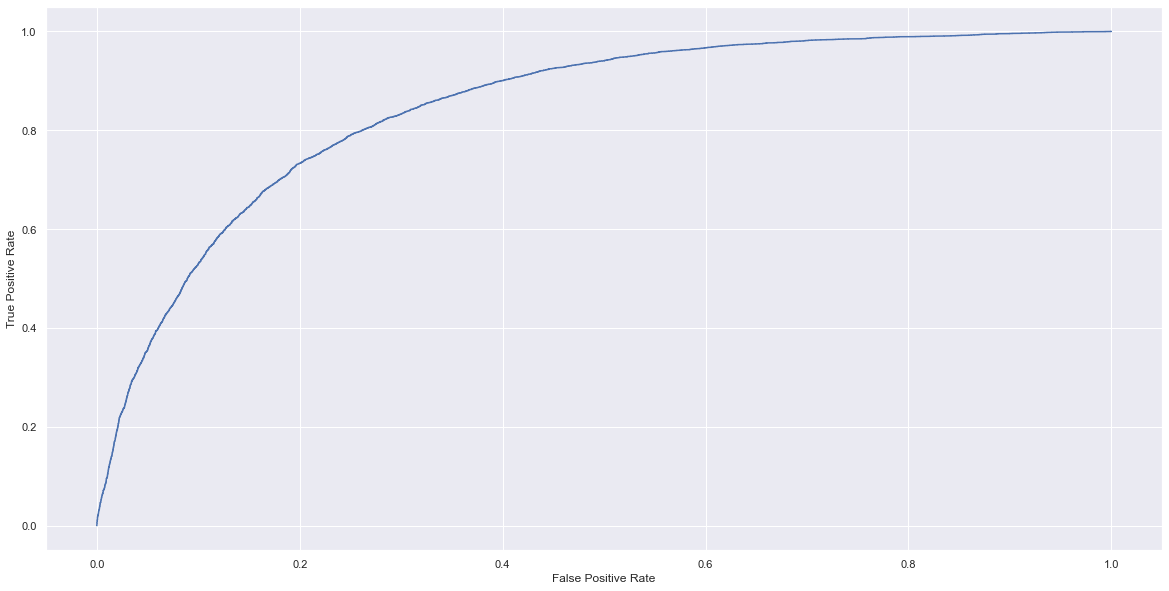

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, pipe_LR.predict_proba(X_test)[:, 1])

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc(fpr, tpr)

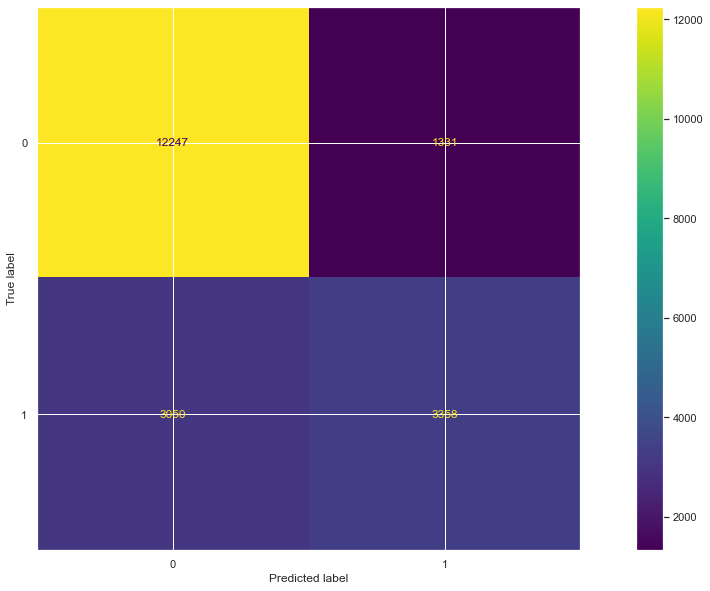

In [79]:
cm = confusion_matrix(y_test, pipe_LR.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [89]:
print('Модель Logistic Regression правильно разметила', abs(1331 / 3358 - 1)*100, '% ушедших клиентов')
print('Модель Logistic Regression правильно разметила', abs(3050 / 12247 - 1)*100, '% оставшихся клиентов')

Модель Logistic Regression правильно разметила 60.363311494937456 % ушедших клиентов
Модель Logistic Regression правильно разметила 75.09594186331347 % оставшихся клиентов


Text(0.5, 1.0, 'Logistic Regression')

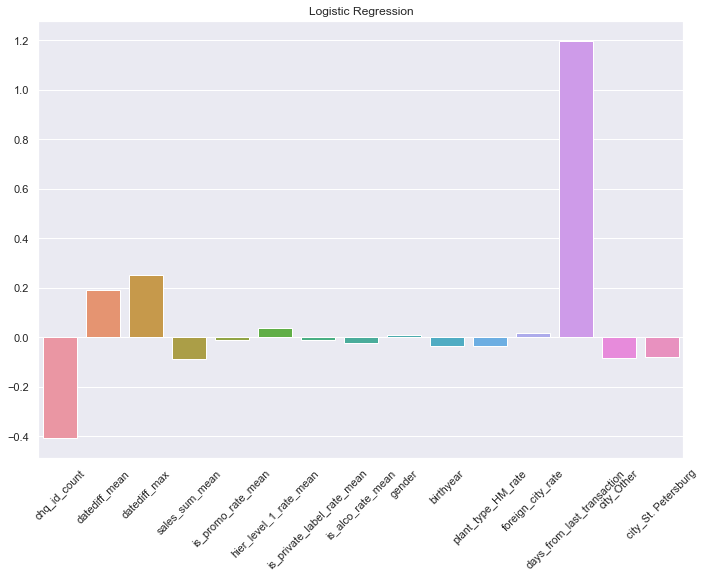

In [81]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.barplot(y=pipe_LR['LogReg'].coef_.tolist()[0], x=X.columns)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Logistic Regression')

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     13578
           1       0.69      0.62      0.65      6408

    accuracy                           0.79     19986
   macro avg       0.76      0.74      0.75     19986
weighted avg       0.79      0.79      0.79     19986



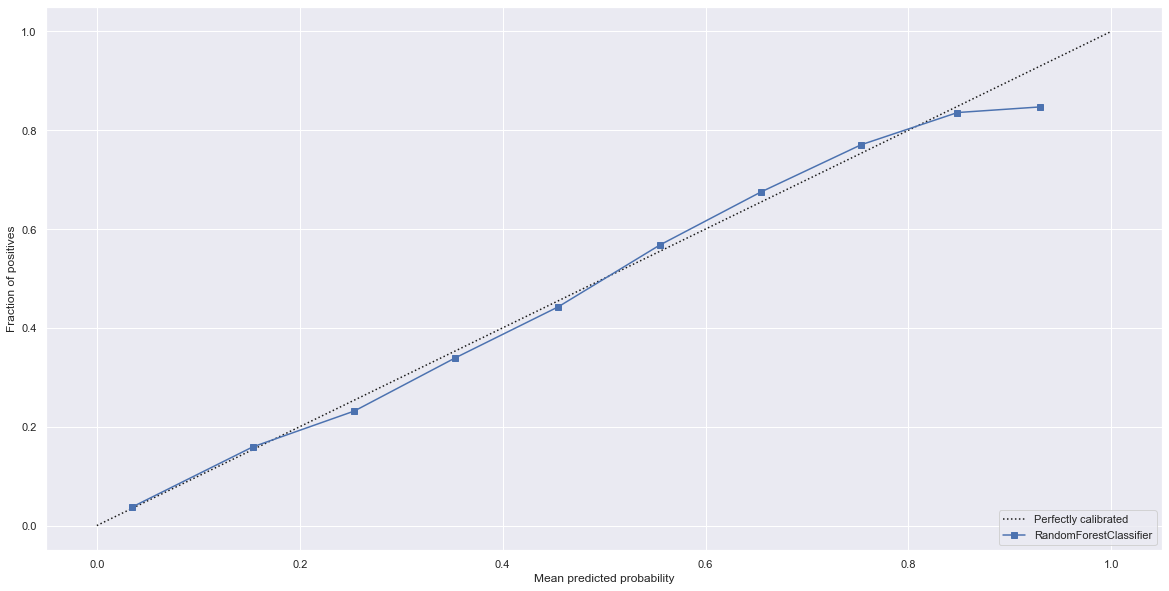

In [82]:
print(classification_report(y_test, RF.predict(X_test)))

CalibrationDisplay.from_estimator(RF, X_test, y_test, n_bins=10)


0.8526473262910242

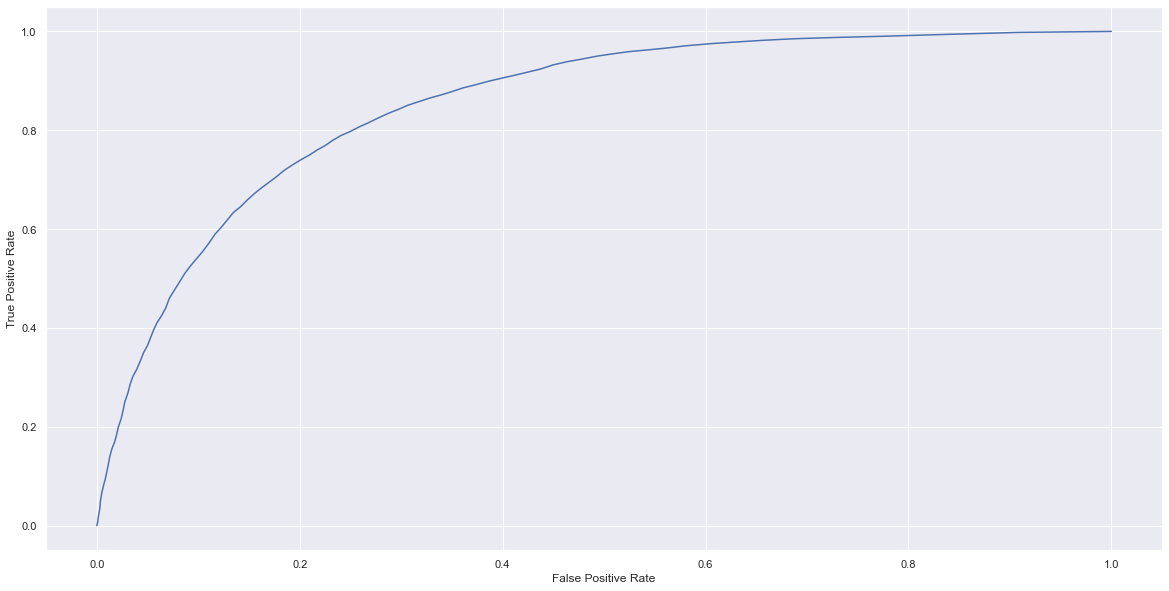

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, RF.predict_proba(X_test)[:, 1])

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

auc(fpr, tpr)

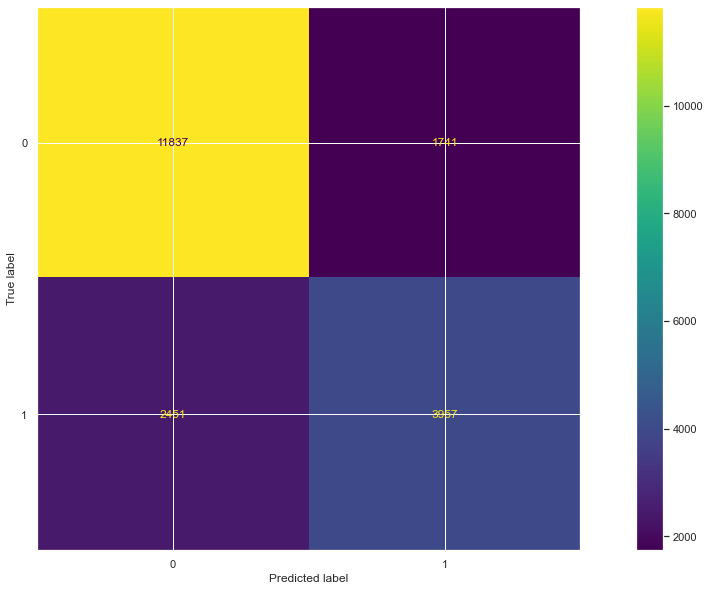

In [84]:
cm = confusion_matrix(y_test, RF.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [87]:
abs(1740 / 3928 - 1), abs(2480 / 11838 - 1)
print('Модель Random Forest правильно разметила', abs(1740 / 3928 - 1)*100, '% ушедших клиентов')
print('Модель Random Forest правильно разметила',  abs(2480 / 11838 - 1)*100, '% оставшихся клиентов')

Модель Random Forest правильно разметила 55.70264765784114 % ушедших клиентов
Модель Random Forest правильно разметила 79.0505152897449 % оставшихся клиентов


Text(0.5, 1.0, 'Random Forest')

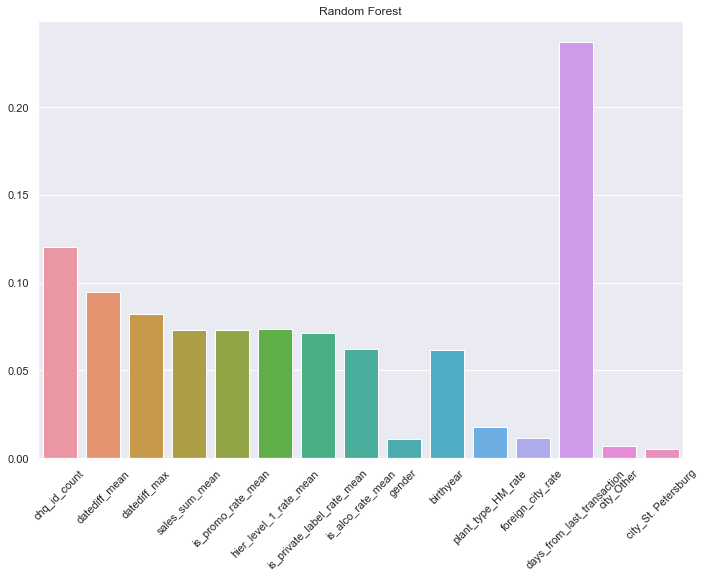

In [86]:
fig = plt.figure()
fig.set_size_inches(10,8)

sns.barplot(y=RF.feature_importances_, x=X.columns)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Random Forest')

### **Выводы после построения дополнительных моделей:**

* Accuracy, f-score и AUC у логрегрессии и случайного леса не сильно отличаются от результатов градиентного бустинга. Это говорит о том, что зависимость таргета от признаков не сложная и скорее всего близка к линейной.
* Логистическая регрессия хуже предсказывает правильные вероятности, если судить по калибровочной кривой. Хотя принято считать, что минимизируя logloss мы всегда корректно предсказываем вероятности.
* Топ признаков, которые модели выделяют как важные, у всех трех моделей не отличаются - количество дней с последнего заказа, среднее и максимальное кол-во дней между заказами и кол-во чеков у клиента. 
* Логистическая регрессия разметила верно больше объектов положительного класса (ушедших клиентов), чем другие модели

### **Как можно улучшить построенные модели и их качество?**

* Сгенерировать больше фичей из имеющихся данных
* Провести подбор гиперпараметров для моделей с GridSearchCV
* Попробовать обучить другие модели, например SVM и KNN
* Написать кастомный трансформер для данных (вместо функций аггрегации), который можно встроить в пайплайн
* Придумать, как аггрегировать признаки товаров hair_level_2, 3, 4 и vendor, которые содержат много уникальных значений